# PyTorch & MNIST Intro

Let's go through a simple example of Pytorch and MNIST as a way to level set NNs and the use of notebooks.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as pl
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Dataset

MNIST is probably the most traditionally used dataset for neural networks, as it is a relatively challenging problem in computer vision: recognizing single-digit numbers from a hand-written digital format. Classically, this dataset takes the form of samples of $28 \times 28$ matrices.

In [41]:
batch_size_train = 64
batch_size_test = 1000

In [42]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train,
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test,
    shuffle=True)

In [43]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

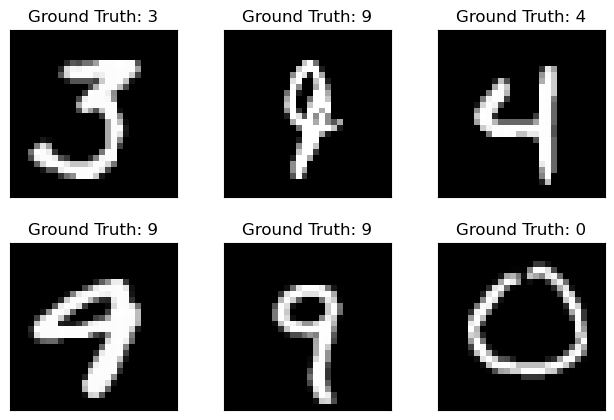

In [44]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Ground Truth: {}".format(example_targets[i]))
    pl.xticks([])
    pl.yticks([])
pl.show()

## Building the model

We need to specify the model through a Python class. Below we show how to create a Feedforward Neural Network model using Pytorch.

In [45]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self):
        input_dim = 28*28
        num_classes = 10
        super(FeedforwardNeuralNetModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, num_classes) 

    def forward(self, x):
        out = self.fc1(x)
        return F.log_softmax(out)

You'll need to instantiate this class as well as an optimizer, which will apply an algorithm to find the internal parameters of that model, such as matrix weights and biases. As an example, we will use the Stochastic Gradient Descent algorithm.

In [47]:
learning_rate = 0.001
momentum = 0.1
log_interval = 10

In [48]:
network = FeedforwardNeuralNetModel()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

## Training

Next, we will define the training procedure.

In [49]:
n_epochs = 5

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [50]:
! mkdir -p results

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file results already exists.
Error occurred while processing: results.


In [51]:
def train(epoch, network):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad() # clears gradients
        output = network(data.reshape(-1, 28*28))
        
        loss = F.nll_loss(output, target)
        loss.backward()
        
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())
            )
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), f'./results/model_iteration-{epoch}.pth')
            torch.save(optimizer.state_dict(), f'./results/optimizer_iteration-{epoch}.pth')

In [52]:
train(1, network)

C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.462653
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.314634
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.172709
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.038150
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.011766
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.793893
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.784094
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.759681
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.595977
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.612938
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.453784
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.386518
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.438524
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.395226
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.237686
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.228426
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.189160
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.303519
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.156207
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.144378
Train Epoch: 1 [12800/60000 (

<br />
Alongside trainig, we will also monitor the performance of the model on a set of samples not seen during the training.

In [53]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.reshape(-1, 28*28))
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n' \
          .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset))
    )

In [54]:
test()

C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
C:\Users\siddu\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5596, Accuracy: 8696/10000 (87%)



## Training and evaluating for multiple epochs

Let's train now for all desired epochs.

In [56]:
for epoch in range(2, n_epochs + 1): # starts from the second iteration
  train(epoch, network)
  test()

C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 2 [0/60000 (0%)]	Loss: 0.666574
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.541078
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.564097
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.666229
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.488056
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.434858
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.543594
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.447622
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.549790
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.652385
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.670172
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.586397
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.554513
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.585009
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.654413
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.667827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.639856
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.650934
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.545639
Train Epoch: 2 [12160/60000 (20%)]	Loss: 0.532475
Train Epoch: 2 [12800/60000 (

# Model performance

Finally, we can inspect the results.

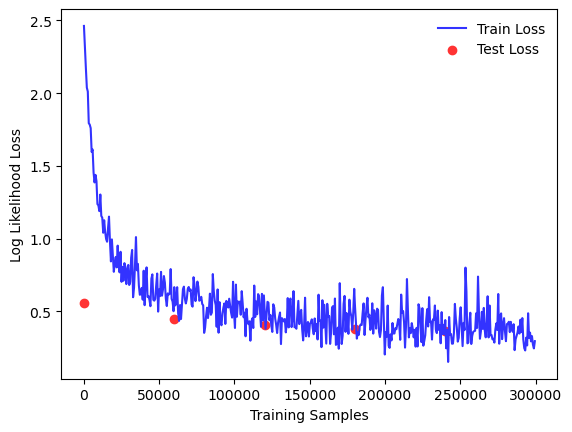

In [57]:
fig = pl.figure()
pl.plot(train_counter, train_losses, color=(0.2, 0.2, 1.0))
pl.scatter(test_counter[:-1], test_losses, color=(1.0, 0.2, 0.2))

pl.legend(['Train Loss', 'Test Loss'], loc='upper right', frameon=False)
pl.xlabel('Training Samples')
pl.ylabel('Log Likelihood Loss')

pl.show()

It's always important to inspect anecdotes to convince yourself the model is behind as expected.

In [58]:
with torch.no_grad():
  output = network(example_data.reshape(1000, 28*28))

C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


**Challenge:** Can you explain why we are using `torch.no_grad()`?

- We use torch.no_grad() when we don't need to calculate gradient in the background for backpropogation. Since we are just getting the output from the test data and not training the model, we use torch.no_grad() to avoid updating the model weights.

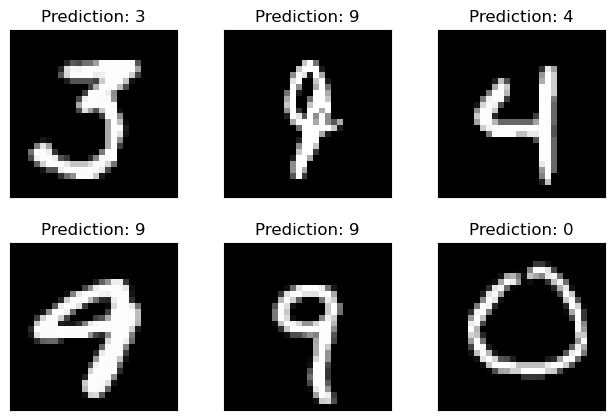

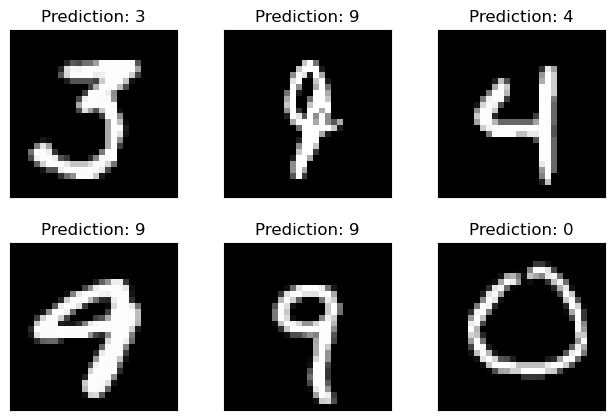

In [59]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2,3,i+1)
    pl.tight_layout()
    pl.imshow(example_data[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()))
    pl.xticks([])
    pl.yticks([])
fig

**Challenge:** Re-do the plot above, but showcasing only miss-classifications (i.e. cases in which the model did wrong).

In [60]:
mismatch = (output.data.max(1, keepdim=True)[1].reshape([1, 1000])[0] != example_targets)
mismatch_labels = output.data.max(1, keepdim=True)[1].reshape([1, 1000])[0][mismatch][:6]
mismatch_example = example_data[mismatch][:6]


In [61]:
mismatch_labels

tensor([6, 4, 6, 9, 7, 2])

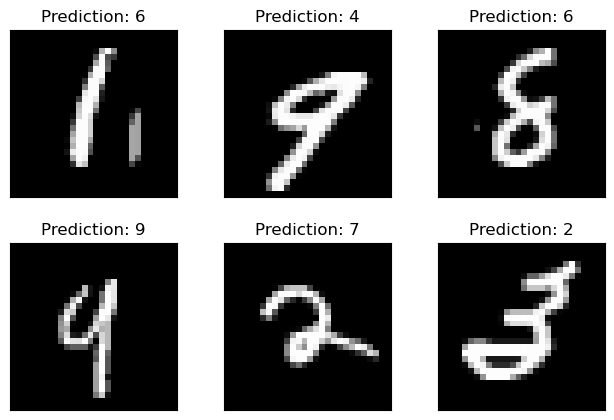

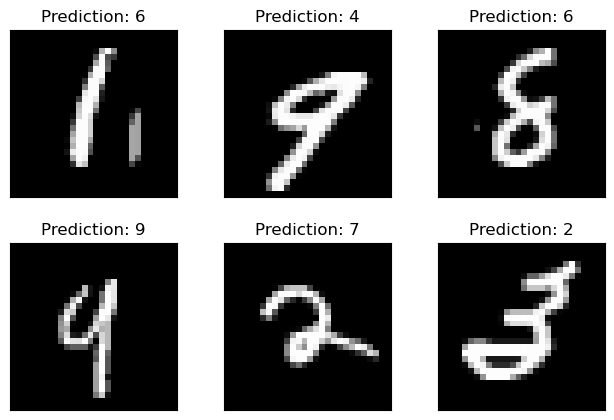

In [62]:
fig = pl.figure()
for i in range(6):
    pl.subplot(2, 3, i + 1)
    pl.tight_layout()
    pl.imshow(mismatch_example[i][0], cmap='gray', interpolation='none')
    pl.title("Prediction: {}".format(mismatch_labels[i].item()))
    pl.xticks([])
    pl.yticks([])

fig

## Loading trained models

Eventually, you will want to load the model you trained in the past for either running inference or continue the training procedure. The functions we developed above save artifacts contain all of the metadata and data about the model, assuming you have the right model class. Let's inspect those files: 

In [63]:
! ls results

model_iteration-1.pth
model_iteration-2.pth
model_iteration-3.pth
model_iteration-4.pth
model_iteration-5.pth
optimizer_iteration-1.pth
optimizer_iteration-2.pth
optimizer_iteration-3.pth
optimizer_iteration-4.pth
optimizer_iteration-5.pth


To load a model:

In [64]:
trained_model = FeedforwardNeuralNetModel()
model_state_dict = torch.load("results/model_iteration-1.pth")
trained_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Before proceeding, let's inspect `model_state_dict`

In [65]:
model_state_dict.keys()

odict_keys(['fc1.weight', 'fc1.bias'])

In [66]:
model_state_dict['fc1.weight'].shape

torch.Size([10, 784])

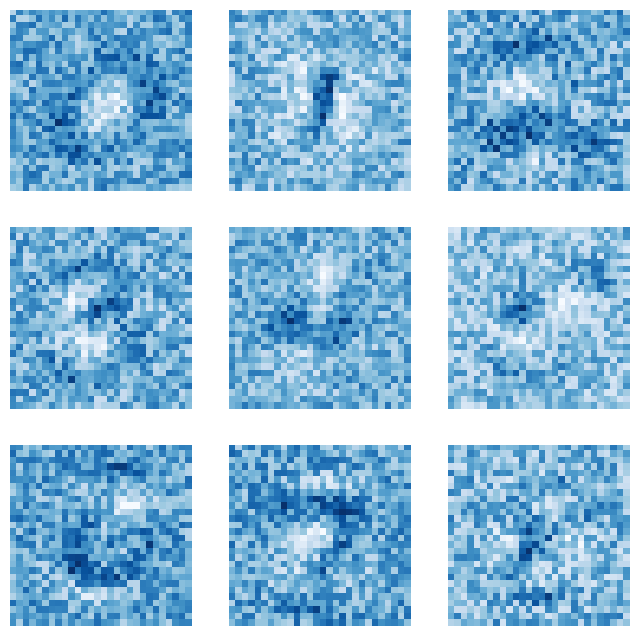

In [67]:
f,axs = pl.subplots(3,3, figsize=(8,8))

c = 0
for ax in axs:
    for sax in ax:
        sax.imshow(model_state_dict['fc1.weight'][c].reshape((28,28)), 
                   cmap = pl.get_cmap('Blues'))
        c += 1
        sax.axis('off')

pl.show()

Let's do the same for the optimizer

In [68]:
optimizer = optim.SGD(trained_model.parameters(), lr=learning_rate, momentum=momentum)
optimizer_state_dict = torch.load("results/optimizer_iteration-3.pth")
optimizer.load_state_dict(optimizer_state_dict)

In [69]:
optimizer_state_dict.keys()

dict_keys(['state', 'param_groups'])

**Challenge:** Can you make sense of the data in this dictionary?

- 'state' key has the values regarding the background values of the optimizer such as the gradients.
- 'param_groups' has the parameters of the optimizer such as the learning rate and momentum.

## Final challenges

* What happens if you use only 10% of the available training data? Plot the difference in performance of the network.
* What happens if you remove 80% of all samples with label 5. Do you see a difference in performance? Is this difference homogeneous?
* What happens if you change parameters like the learnign rate and momentum? Plot the difference.
* Can you add more layers to this neural network? Start with one additional layer (often called "hidden layer"). What changes can you observe in doing so?
* Can you add regularization to this model? Look for L1, L2, and drop-out regularizations. What changes do you observe?
* [stretch] Can you change this model and turn it into a convolutional neural network?

## Challenge 1 ##

In [70]:
def train(epoch, network, train_loader, optimizer, log_interval, loss_lst):
        network.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(data.view(-1, 28*28))
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if batch_idx % log_interval == 0:
                print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        loss_lst.append(train_loss / len(train_loader.dataset))

def test(network, test_loader, loss_lst):
        network.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                output = network(data.view(-1, 28*28))
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        loss_lst.append(test_loss)
        print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

In [71]:
train_data_10_percent = torch.utils.data.Subset(train_loader.dataset, range(int(len(train_loader.dataset) * 0.1)))
train_loader_10_percent = torch.utils.data.DataLoader(dataset=train_data_10_percent, batch_size=batch_size_train, shuffle=True)
train_losses_10_percent = []
train_losses_full = []
test_losses = []

In [72]:
network_10_percent = FeedforwardNeuralNetModel()
optimizer_10_percent = optim.SGD(network_10_percent.parameters(), lr=learning_rate, momentum=momentum)
network_full = FeedforwardNeuralNetModel()
optimizer_full = optim.SGD(network_full.parameters(), lr=learning_rate, momentum=momentum)

In [73]:
for epoch in range(1, 6): 
    train(epoch, network_10_percent, train_loader_10_percent, optimizer_10_percent, log_interval, train_losses_10_percent)


C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/6000 (0%)]	Loss: 2.472538
Train Epoch: 1 [640/6000 (11%)]	Loss: 2.092759
Train Epoch: 1 [1280/6000 (21%)]	Loss: 2.045848
Train Epoch: 1 [1920/6000 (32%)]	Loss: 1.995059
Train Epoch: 1 [2560/6000 (43%)]	Loss: 1.883918
Train Epoch: 1 [3200/6000 (53%)]	Loss: 1.692624
Train Epoch: 1 [3840/6000 (64%)]	Loss: 1.664274
Train Epoch: 1 [4480/6000 (74%)]	Loss: 1.621138
Train Epoch: 1 [5120/6000 (85%)]	Loss: 1.469161
Train Epoch: 1 [5760/6000 (96%)]	Loss: 1.487101
Train Epoch: 2 [0/6000 (0%)]	Loss: 1.506710
Train Epoch: 2 [640/6000 (11%)]	Loss: 1.392102
Train Epoch: 2 [1280/6000 (21%)]	Loss: 1.292386
Train Epoch: 2 [1920/6000 (32%)]	Loss: 1.319497
Train Epoch: 2 [2560/6000 (43%)]	Loss: 1.128795
Train Epoch: 2 [3200/6000 (53%)]	Loss: 1.215898
Train Epoch: 2 [3840/6000 (64%)]	Loss: 1.106416
Train Epoch: 2 [4480/6000 (74%)]	Loss: 1.057016
Train Epoch: 2 [5120/6000 (85%)]	Loss: 1.069672
Train Epoch: 2 [5760/6000 (96%)]	Loss: 1.079658
Train Epoch: 3 [0/6000 (0%)]	Loss: 1.036136
Train 

In [74]:
for epoch in range(1, 6):
    train(epoch, network_full, train_loader, optimizer_full, log_interval, train_losses_full)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.589556
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.340764


C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.064073
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.107391
Train Epoch: 1 [2560/60000 (4%)]	Loss: 1.940965
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.812450
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.712466
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.621950
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.706449
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.475927
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.452131
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.488790
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.374091
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.381625
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.414379
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.333127
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.198524
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.271147
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.301459
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.207279
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.993097
Train Epoch: 1 [13440/60000 (22%)]	Loss: 1.169950
Train Epoch: 1 [14080

In [75]:
train_losses_10_percent

[0.028796058237552644,
 0.01983638068040212,
 0.015727343410253523,
 0.0134519026974837,
 0.011989882131417592]

In [76]:
train_losses_full

[0.014688171982765197,
 0.008180707888801892,
 0.007041451971977949,
 0.006490226897845666,
 0.006148999314258496]

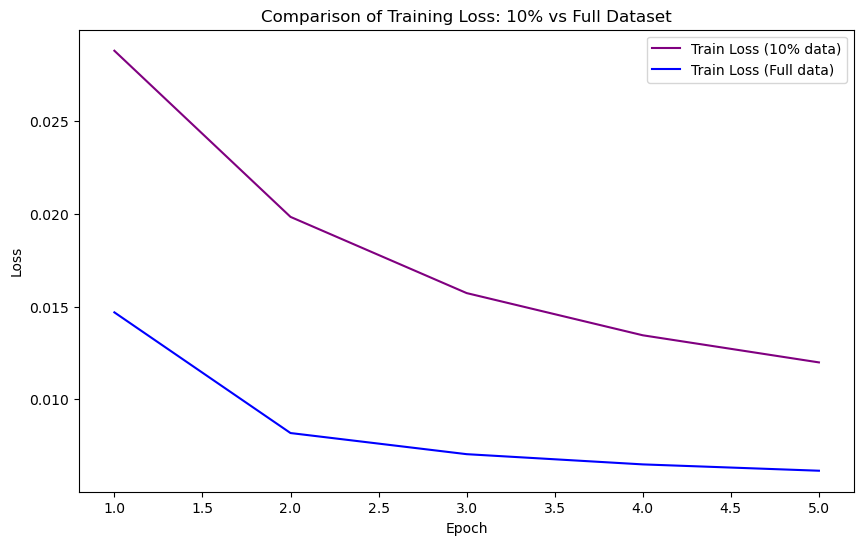

In [77]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 6), train_losses_10_percent, label='Train Loss (10% data)', color='purple')
pl.plot(range(1, 6), train_losses_full, label='Train Loss (Full data)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Comparison of Training Loss: 10% vs Full Dataset')
pl.legend()
pl.show()

## Challenge 2 ##

In [78]:
import numpy as np

In [79]:
targets = train_loader.dataset.targets
labels = np.array(targets)

In [80]:
idx_5 = np.where(labels == 5)[0]
idx_5

array([    0,    11,    35, ..., 59968, 59993, 59997], dtype=int64)

In [81]:
indices_80 = np.random.choice(idx_5, int(0.8 * (len(idx_5))), replace=False)
idx_all = np.concatenate([np.where(labels != 5)[0], indices_80])
idx_all

array([    1,     2,     3, ..., 47854, 54483, 10894], dtype=int64)

In [82]:
train_data_80_5 = torch.utils.data.Subset(train_loader.dataset, idx_all)
train_loader_80_5 = torch.utils.data.DataLoader(dataset=train_data_80_5, batch_size=batch_size_train, shuffle=True)
network_80_5 = FeedforwardNeuralNetModel()
optimizer_80_5 = optim.SGD(network_80_5.parameters(), lr=learning_rate, momentum=momentum)
train_losses_80_5 = []
test_losses_80_5 = []

In [83]:
for epoch in range(1, 6):
    train(epoch, network_80_5, train_loader_80_5, optimizer_80_5, log_interval, train_losses_80_5)
    test(network_80_5, test_loader, test_losses_80_5)

C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [0/58915 (0%)]	Loss: 2.546813
Train Epoch: 1 [640/58915 (1%)]	Loss: 2.472836
Train Epoch: 1 [1280/58915 (2%)]	Loss: 2.303257
Train Epoch: 1 [1920/58915 (3%)]	Loss: 2.233498
Train Epoch: 1 [2560/58915 (4%)]	Loss: 1.968129
Train Epoch: 1 [3200/58915 (5%)]	Loss: 2.039403
Train Epoch: 1 [3840/58915 (7%)]	Loss: 1.848759
Train Epoch: 1 [4480/58915 (8%)]	Loss: 1.727594
Train Epoch: 1 [5120/58915 (9%)]	Loss: 1.729127
Train Epoch: 1 [5760/58915 (10%)]	Loss: 1.608333
Train Epoch: 1 [6400/58915 (11%)]	Loss: 1.488316
Train Epoch: 1 [7040/58915 (12%)]	Loss: 1.532000
Train Epoch: 1 [7680/58915 (13%)]	Loss: 1.419510
Train Epoch: 1 [8320/58915 (14%)]	Loss: 1.301836
Train Epoch: 1 [8960/58915 (15%)]	Loss: 1.346792
Train Epoch: 1 [9600/58915 (16%)]	Loss: 1.307413
Train Epoch: 1 [10240/58915 (17%)]	Loss: 1.232991
Train Epoch: 1 [10880/58915 (18%)]	Loss: 1.389123
Train Epoch: 1 [11520/58915 (20%)]	Loss: 1.182996
Train Epoch: 1 [12160/58915 (21%)]	Loss: 1.216894
Train Epoch: 1 [12800/58915 (

In [84]:
for epoch in range(1, 6):
    train(epoch, network_full, train_loader, optimizer_full, log_interval, train_losses_full)
    test(network_full, test_loader, test_losses)
    

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.350681
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.402402
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.300496


C:\Users\siddu\AppData\Local\Temp\ipykernel_23908\3418281087.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.651740
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.606013
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.556523
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.281246
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.310378
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.345308
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.414900
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.650204
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.355549
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.522847
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.437609
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.354652
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.350534
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.589593
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.415829
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.240318
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.152730
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.515602
Train Epoch: 1 [13440/60000 (22%)]	Loss: 0.325118
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.423117
Train Epoch: 1 [147

In [85]:
test_losses_80_5

[0.5751296936035156,
 0.458672216796875,
 0.4137790985107422,
 0.38792298889160154,
 0.3698630981445313]

In [86]:
test_losses

[0.3556050842285156,
 0.34636712646484374,
 0.33887917785644533,
 0.33300447692871094,
 0.3275403747558594]

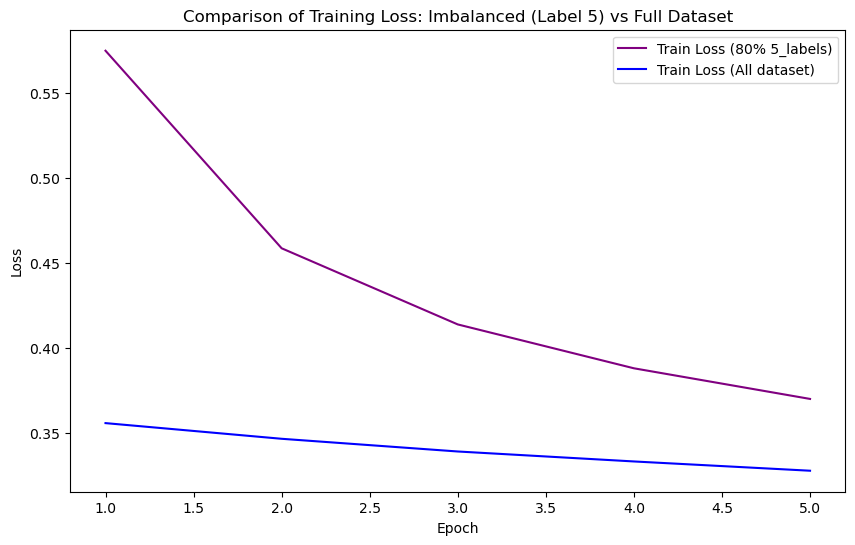

In [90]:
pl.figure(figsize=(10, 6))
pl.plot(range(1, 6), test_losses_80_5, label='Train Loss (80% 5_labels)', color='purple')
pl.plot(range(1, 6), test_losses, label='Train Loss (All dataset)', color='blue')
pl.xlabel('Epoch')
pl.ylabel('Loss')
pl.title('Comparison of Training Loss: Imbalanced (Label 5) vs Full Dataset')
pl.legend()
pl.show()